In [253]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
import numpy as np
from tqdm import tqdm
from mug_cakes import bo, gp, kernel
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from mug_cakes import utils

In [391]:
# pick parameters for GP
s2f = 15
scale = 0.05
s2e = 1 ** 2 
x_true = np.array([s2f, scale, s2e])
J = 2
var_b = 5 ** 2

In [447]:
def closure():
    eps = 0.000001
    xa = (res.x + 1).copy()
    xb = xa.copy()
    xb[1] += eps
    est = (bo._hp_target(xb, X, Y, 2, B, var_b) - bo._hp_target(xa, X, Y, 2, B, var_b)) / eps
    print(bo._dhp_target(xa, X, Y, 2, B, var_b))
    print(est)
    # N = X.shape[0]
    # log_s2f, log_scale, log_s2e = x0
    # s2f = np.exp(log_s2f)
    # scale = np.exp(log_scale)
    # s2e = np.exp(log_s2e)
    # K = kernel.rbf(X, X, scale, s2f)
    # vara = bo.full_cov(K[None], 2, s2e, 1)[0, :N, :N]
    # varb = bo.full_cov(K[None], 2, s2e + eps, 1)[0, :N, :N]
    # print((varb - vara)/eps)
    # print(bo.full_cov(np.zeros((N,N)), 2, 1, 0)[0, :N, :N])
closure()

[-12.11343487  22.33587125  -0.49133517]
22.33590425504417


In [394]:
%%time
N = 20 * J
P = 50
bounds = ((-1, 4), (-7, 4), (-7, 4))
# running_sum = 0
# for _ in tqdm(range(P)):
#     x_0 = np.array([0, 0, 0])
#     X = np.linspace(0,1, N // J).reshape(-1, 1)
#     X = utils.rowpeat(X, 2)
#     K = kernel.rbf(X, X, scale, s2f)
#     var = bo.full_cov(K, 2, s2e, var_b)
#     Y = stats.multivariate_normal.rvs(cov = var)[:N]
#     res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,2,var_b), bounds=bounds)
#     running_sum += np.exp(res.x)
# print(running_sum / P, x_true)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [500]:
N = 10 * J

# sample data
X = np.linspace(0,1, N // J).reshape(-1, 1)
X = np.random.rand(N, 1)
B = np.zeros(N, dtype=np.uint64)
B[:N // 2] = 1
X[:N // 2] -= 0.5
# X = utils.rowpeat(X, J)
K = kernel.rbf(X, X, scale, s2f)
var = bo.full_cov(K, J, B, s2e, var_b)
Y = stats.multivariate_normal.rvs(cov = var)[:N]
# Y *= 0
# Y[::2] =3
# Y[1::2] =-3

# fit hyperparameters
x0 = np.array([0, 0, 0])
# res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,J,var_b), bounds=bounds)


[12.05894332  0.02731822  0.45483871]


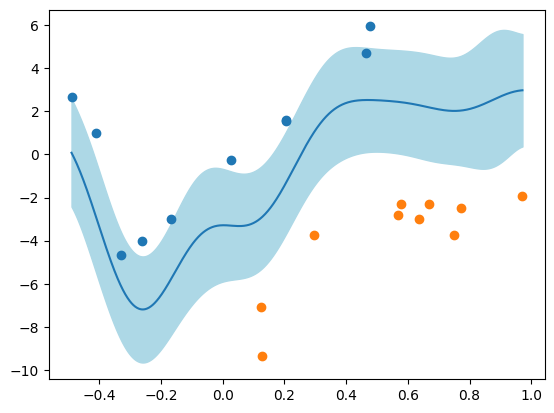

In [501]:
hparams_mle = bo.optimize_rbf_params(X, Y, J, B, var_b)
# hparams_mle[0] = 100
X_star = np.linspace(X.min(), X.max(), N_star).reshape(-1, 1)
K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
var = bo.full_cov(K, J, B, hparams_mle[2], var_b)[:N, :N]
K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
post_mean2 = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
post_var2 = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)
print(hparams_mle)

plt.fill_between(X_star.reshape(-1), post_mean2 - post_var2, post_mean2 + post_var2, color="lightblue")
plt.scatter(X[B == 1], Y[B == 1])
plt.scatter(X[B == 0], Y[B == 0])
plt.plot(X_star, post_mean2);

[1.09228179e+01 9.80952278e-04 3.08067850e-01]


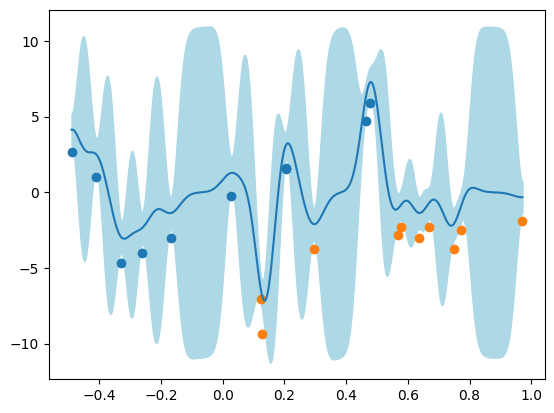

In [502]:
B1 = np.zeros_like(Y, dtype=np.uint64)

N_star = 1000
hparams_mle = bo.optimize_rbf_params(X, Y, J, B1, var_b)
X_star = np.linspace(X.min(), X.max(), N_star).reshape(-1, 1)
K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
var = bo.full_cov(K, 1, B1, hparams_mle[2], var_b)[:N, :N]
K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
post_mean = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
post_var = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)
print(hparams_mle)

plt.fill_between(X_star.reshape(-1), post_mean - post_var, post_mean + post_var, color="lightblue")
plt.scatter(X[B == 1], Y[B == 1])
plt.scatter(X[B == 0], Y[B == 0])
plt.plot(X_star, post_mean);

In [ ]:
## 